In [1]:
import pandas as pd

## import data

In [2]:
hrst_st_rsex=pd.read_csv('data/hrst_st_rsex_page_linear.csv')

In [3]:
lfsa_ewhais=pd.read_csv('data/lfsa_ewhais_page_linear.csv')

In [4]:
prc_ppp_ind=pd.read_csv('data/prc_ppp_ind_page_linear.csv')

In [5]:
sbs_ovw_act=pd.read_csv('data/sbs_ovw_act_page_linear.csv')

## process data

In [6]:
pd.DataFrame(hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['F']/hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['T'])

,0
geo,
AT,0.500863
BA,0.510067
BE,0.526191
BG,0.582070
CH,0.493922
CY,0.529859
CZ,0.492497
DE,0.519083
DK,0.502393


In [7]:
def process_csv(df):
    return (df.set_index('geo')[['OBS_VALUE']])

In [9]:
merged_stats=(lfsa_ewhais
 .pipe(process_csv)
 .assign(prc_ppp=prc_ppp_ind
        .pipe(process_csv),
         sbs_ovw=sbs_ovw_act
        .pipe(process_csv),
         hrst_st=pd.DataFrame(hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['F']/hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['T']),
        )
             )
        
              #.reset_index()
              #.query('geo!="EU27_2020"')


In [11]:
# normalized_df=(df-df.min())/(df.max()-df.min())


In [14]:
minmax_normalised_stats=((merged_stats-merged_stats.min(numeric_only=True))/(merged_stats.max(numeric_only=True)-merged_stats.min(numeric_only=True))).dropna()


In [15]:
minmax_normalised_stats

,OBS_VALUE,prc_ppp,sbs_ovw,hrst_st
geo,,,,
AT,0.116667,0.022656,0.014899,0.329388
BE,0.225000,0.028871,0.017731,0.462405
BG,0.566667,0.009359,0.005412,0.755865
CY,0.525000,0.001018,0.003804,0.481671
CZ,0.466667,0.018116,0.030176,0.285452
DE,0.150000,0.215970,0.097330,0.425074
DK,0.175000,0.013468,0.018673,0.337424
EE,0.350000,0.001318,0.003614,0.883553
EL,0.633333,0.017443,0.019287,0.470062


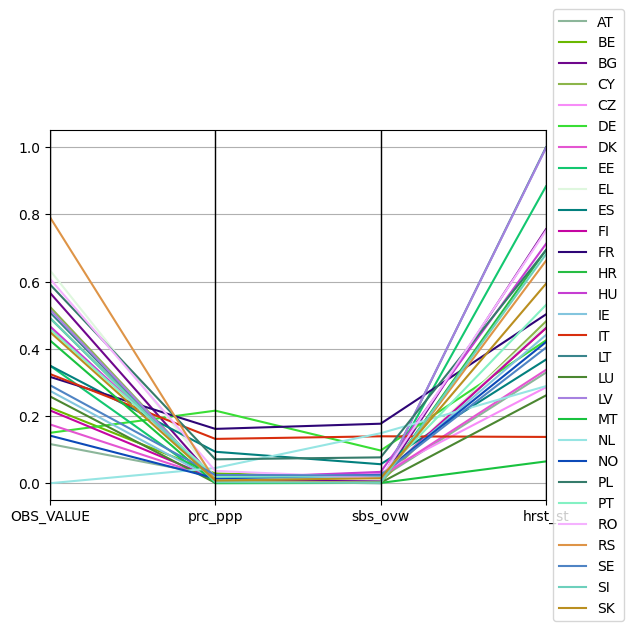

In [16]:
pd.plotting.parallel_coordinates(minmax_normalised_stats.reset_index(),'geo').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

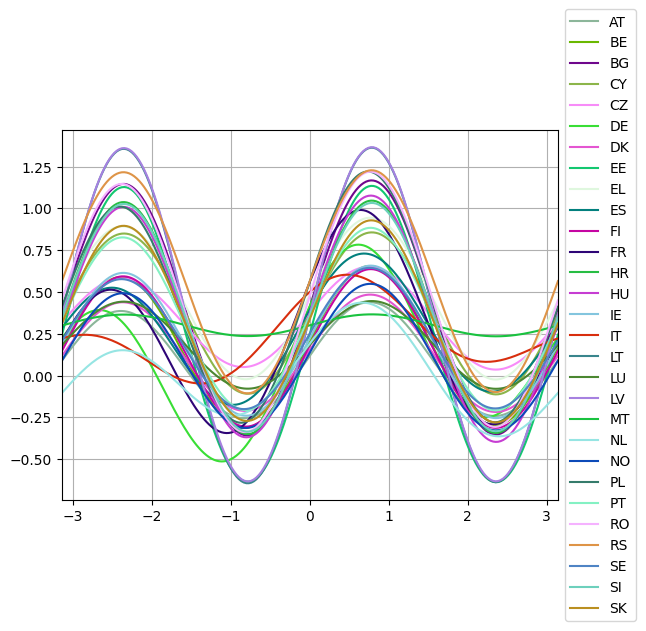

In [19]:
pd.plotting.andrews_curves(minmax_normalised_stats.reset_index(),'geo').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

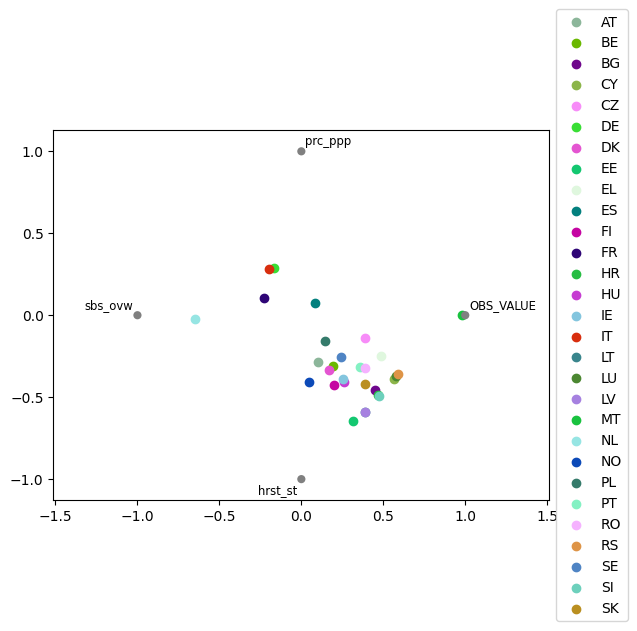

In [17]:
pd.plotting.radviz(minmax_normalised_stats.reset_index(),'geo').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
